In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import csv

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

In [22]:
fold = 'fold_3'

### Preprocessing

In [23]:
# cria um dicionario com a chave sendo cada k_fold e os values são outro dicionario com cada key sendo o tipo de objeto (treinamento ou validacao) e os valores são um dataframe
k_folds = { fold : {"x_train": pd.read_csv(f'./K Folds Cross Validation/{fold}/x_train_{fold}').drop("Unnamed: 0", axis = 1),
                    "x_val": pd.read_csv(f'./K Folds Cross Validation/{fold}/x_val_{fold}').drop("Unnamed: 0", axis = 1),
                    "y_train": pd.read_csv(f'./K Folds Cross Validation/{fold}/y_train_{fold}').drop("Unnamed: 0", axis = 1)['weather'],  #abre o dataframe e ja faz o mapeamento
                    "y_val": pd.read_csv(f'./K Folds Cross Validation/{fold}/y_val_{fold}').drop("Unnamed: 0", axis = 1)['weather'],}     #abre o dataframe e ja faz o mapeamento
                     
                     for fold in os.listdir("./K Folds Cross Validation/")}
    
k_folds

{'fold_0': {'x_train':        season  humidity  pressure  temperature  wind
  0         0.0        69      1015            4     3
  1         0.0        51      1022            0     5
  2         0.0        51      1022           -1     4
  3         0.0        55      1022           -1     4
  4         0.0        51      1022           -1     5
  ...       ...       ...       ...          ...   ...
  34859     0.0        36      1019           16     3
  34860     0.0        38      1019           16     1
  34861     0.0        54      1019           14     2
  34862     0.0        62      1020           12     3
  34863     0.0        58      1020           11     2
  
  [34864 rows x 5 columns],
  'x_val':       season  humidity  pressure  temperature  wind
  0      0.000        58      1012           15     7
  1      0.000        57      1012           15     7
  2      0.000        57      1012           15     7
  3      0.000        57      1012           15     7
  4      

In [24]:
x_train = k_folds.get(fold).get('x_train')
y_train = k_folds.get(fold).get('y_train')

x_test = k_folds.get(fold).get('x_val')
y_test = k_folds.get(fold).get('y_val')

In [25]:
dataset = pd.concat([x_train, y_train], axis = 1)
dataset_test = pd.concat([x_test, y_test], axis = 1)
dataset

,season,humidity,pressure,temperature,wind,weather
0,0.0,58,1012,15,7,0
1,0.0,57,1012,15,7,0
2,0.0,57,1012,15,7,0
3,0.0,57,1012,15,7,0
4,0.0,57,1012,15,6,0
...,...,...,...,...,...,...
34859,0.0,36,1019,16,3,3
34860,0.0,38,1019,16,1,3
34861,0.0,54,1019,14,2,3
34862,0.0,62,1020,12,3,3


In [26]:
weather_rkm = pd.read_csv('weather_reverse_key_mapping.csv', index_col= 'code')#.drop(['0'], axis = 1)
season_rkm = pd.read_csv('season_reverse_key_mapping.csv', index_col= 'code')#.drop(['0.0'], axis = 1)

In [27]:
weather_reverse_key_mapping = {code : weather_rkm.loc[code].item() for code in weather_rkm.index}
season_reverse_key_mapping = {code : season_rkm.loc[code].item() for code in season_rkm.index}


In [28]:
dataset['weather'] = dataset['weather'].map(weather_reverse_key_mapping)
dataset['season'] = dataset['season'].map(season_reverse_key_mapping)

dataset_test['weather'] = dataset_test['weather'].map(weather_reverse_key_mapping)
dataset_test['season'] = dataset_test['season'].map(season_reverse_key_mapping)

In [29]:
dataset

,season,humidity,pressure,temperature,wind,weather
0,spring,58,1012,15,7,few_clouds
1,spring,57,1012,15,7,few_clouds
2,spring,57,1012,15,7,few_clouds
3,spring,57,1012,15,7,few_clouds
4,spring,57,1012,15,6,few_clouds
...,...,...,...,...,...,...
34859,spring,36,1019,16,3,sky_is_clear
34860,spring,38,1019,16,1,sky_is_clear
34861,spring,54,1019,14,2,sky_is_clear
34862,spring,62,1020,12,3,sky_is_clear


In [30]:
dataset_test

,season,humidity,pressure,temperature,wind,weather
0,summer,64,1027,2,4,heavy_snow
1,summer,64,1027,2,3,heavy_snow
2,summer,55,1013,1,8,heavy_snow
3,autumn,60,1008,3,7,heavy_snow
4,autumn,59,1006,3,5,heavy_snow
...,...,...,...,...,...,...
8711,winter,82,1014,18,2,thunderstorm_with_light_rain
8712,winter,93,1009,14,2,proximity_thunderstorm
8713,winter,34,1010,34,5,proximity_thunderstorm
8714,winter,40,1011,30,1,thunderstorm_with_light_rain


### Probability

In [31]:
p_of_ = {}
p_of_['weather'] = {weather : 0 for weather in sorted(pd.unique(dataset["weather"]))}

In [32]:
# P(X = weather)

count = 0
for weather in p_of_['weather'].keys():
    for index in range(len(dataset['weather'])):
        if dataset.loc[index, 'weather'] == weather:
            count+=1
    p_of_['weather'][weather] = count/len(dataset['weather'])

    count = 0
    
p_of_['weather']

{'broken_clouds': 0.1409189995410739,
 'drizzle': 0.00510555300596604,
 'dust': 0.0004876089949518128,
 'few_clouds': 0.07497705369435521,
 'fog': 0.024695961450206517,
 'haze': 0.01583295089490592,
 'heavy_intensity_drizzle': 0.0004589261128958238,
 'heavy_intensity_rain': 0.00846145020651675,
 'heavy_snow': 0.0027535566773749425,
 'light_intensity_drizzle': 0.009207205139972464,
 'light_rain': 0.09058054153281321,
 'light_rain_and_snow': 0.0002581459385039009,
 'light_snow': 0.00877696190913263,
 'mist': 0.12388136759981642,
 'moderate_rain': 0.021397430013767784,
 'overcast_clouds': 0.09904199173932997,
 'proximity_thunderstorm': 0.002610142267094998,
 'scattered_clouds': 0.10291418081688848,
 'sky_is_clear': 0.2602397888939881,
 'snow': 0.00226594768242313,
 'thunderstorm': 0.0016922900413033502,
 'thunderstorm_with_heavy_rain': 0.0002868288205598899,
 'thunderstorm_with_light_rain': 0.0008318035796236806,
 'thunderstorm_with_rain': 0.0004589261128958238,
 'very_heavy_rain': 0.0018

In [33]:
sum = 0
for value in p_of_['weather'].values():
    sum+= value
sum




0.9999999999999999

In [34]:
#cria a pmf de cada variavel climatica (termo normalizador (denominador da fração) da equação do Teorema de Bayes )

#desabilitado por causa da simplificação da equação
# for variavel_climatica in ['season', 'humidity', 'pressure', 'temperature', 'wind']:
#     p_of_[variavel_climatica] = {i : dataset[variavel_climatica].value_counts(normalize = True)[i] for i in dataset[variavel_climatica].value_counts(normalize = True).index}

# p_of_.keys()

dict_keys(['weather', 'season', 'humidity', 'pressure', 'temperature', 'wind'])

In [35]:
# verifica a probabilidade total de cada variavel climatica 

# for variavel_climatica in ['season', 'humidity', 'pressure', 'temperature', 'wind']:
#     sum = 0
#     for value in p_of_[variavel_climatica].values():
#         sum+= value
#     print(sum)

1.0
1.0000000000000002
0.9999999999999996
1.0000000000000004
1.0000000000000002


In [36]:
dataset['weather'].value_counts(normalize = True)

weather
sky_is_clear                    0.260240
broken_clouds                   0.140919
mist                            0.123881
scattered_clouds                0.102914
overcast_clouds                 0.099042
light_rain                      0.090581
few_clouds                      0.074977
fog                             0.024696
moderate_rain                   0.021397
haze                            0.015833
light_intensity_drizzle         0.009207
light_snow                      0.008777
heavy_intensity_rain            0.008461
drizzle                         0.005106
heavy_snow                      0.002754
proximity_thunderstorm          0.002610
snow                            0.002266
very_heavy_rain                 0.001864
thunderstorm                    0.001692
thunderstorm_with_light_rain    0.000832
dust                            0.000488
heavy_intensity_drizzle         0.000459
thunderstorm_with_rain          0.000459
thunderstorm_with_heavy_rain    0.000287
light_ra

In [37]:
p_of_['weather']

{'broken_clouds': 0.1409189995410739,
 'drizzle': 0.00510555300596604,
 'dust': 0.0004876089949518128,
 'few_clouds': 0.07497705369435521,
 'fog': 0.024695961450206517,
 'haze': 0.01583295089490592,
 'heavy_intensity_drizzle': 0.0004589261128958238,
 'heavy_intensity_rain': 0.00846145020651675,
 'heavy_snow': 0.0027535566773749425,
 'light_intensity_drizzle': 0.009207205139972464,
 'light_rain': 0.09058054153281321,
 'light_rain_and_snow': 0.0002581459385039009,
 'light_snow': 0.00877696190913263,
 'mist': 0.12388136759981642,
 'moderate_rain': 0.021397430013767784,
 'overcast_clouds': 0.09904199173932997,
 'proximity_thunderstorm': 0.002610142267094998,
 'scattered_clouds': 0.10291418081688848,
 'sky_is_clear': 0.2602397888939881,
 'snow': 0.00226594768242313,
 'thunderstorm': 0.0016922900413033502,
 'thunderstorm_with_heavy_rain': 0.0002868288205598899,
 'thunderstorm_with_light_rain': 0.0008318035796236806,
 'thunderstorm_with_rain': 0.0004589261128958238,
 'very_heavy_rain': 0.0018

In [38]:
# calcula a probabilidade condicional de cada variavel climatica dado o clima (P = var_clim | Clima)
conditional_probability = {}

for weather in pd.unique(dataset['weather']):
    count = 0
    for variavel_climatica in ['season', 'humidity', 'pressure', 'temperature', 'wind']:
        temporary_dataset = dataset[dataset['weather'].str.contains(f'{weather}|{variavel_climatica}')][[variavel_climatica,'weather']]  # cria um sliced dataset temporario 
        for index in temporary_dataset.index:  
            if temporary_dataset.loc[index, 'weather'] != weather:  # valida que df['weather'][i] é estritamente igual à weather do loop
                temporary_dataset.drop( index = index, inplace = True)

        # calcula a probabilidade condicional
        conditional_probability[f"{variavel_climatica}_given_{weather}"] = {i[0] : temporary_dataset.value_counts(normalize = True)[i] for i in temporary_dataset.value_counts(normalize = True).index  }

In [39]:
conditional_probability

{'season_given_few_clouds': {'autumn': 0.27850038255547055,
  'winter': 0.2620504973221117,
  'spring': 0.2543993879112471,
  'summer': 0.20504973221117062},
 'humidity_given_few_clouds': {48: 0.02754399387911247,
  45: 0.0252486610558531,
  69: 0.02486610558530987,
  51: 0.0225707727620505,
  41: 0.0225707727620505,
  52: 0.02218821729150727,
  44: 0.02218821729150727,
  60: 0.02218821729150727,
  64: 0.02142310635042081,
  53: 0.02142310635042081,
  58: 0.021040550879877582,
  42: 0.020657995409334353,
  54: 0.020275439938791124,
  56: 0.020275439938791124,
  57: 0.019510328997704666,
  55: 0.019510328997704666,
  47: 0.01874521805661821,
  73: 0.018362662586074982,
  68: 0.017597551644988524,
  71: 0.017597551644988524,
  50: 0.017214996174445295,
  62: 0.017214996174445295,
  61: 0.016067329762815608,
  46: 0.016067329762815608,
  49: 0.01568477429227238,
  59: 0.015302218821729151,
  34: 0.015302218821729151,
  77: 0.014919663351185922,
  37: 0.014919663351185922,
  43: 0.01491966

In [40]:
# verifica a probabilidade total de cada probabilidade condicional (∑ p(xi|y) = 1) / xi em variavel climatica

for variavel_climatica in ['season','humidity', 'pressure', 'temperature', 'wind']:
    for weather in pd.unique(dataset['weather']):
        probability = 0
        for prob in conditional_probability[f'{variavel_climatica}_given_{weather}'].values():
            probability += prob
        print(probability)

1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
0.9999999999999998
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999994
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0000000000000004
1.0
0.9999999999999996
0.9999999999999996
1.0000000000000007
0.9999999999999998
1.0
0.9999999999999987
1.0
0.9999999999999996
0.9999999999999996
0.9999999999999997
0.9999999999999998
1.0
0.9999999999999999
0.9999999999999996
0.9999999999999991
1.0
0.9999999999999999
1.0000000000000007
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999998
1.0000000000000002
1.0000000000000004
1.0
1.0000000000000002
0.9999999999999998
1.0000000000000002
0.9999999999999999
1.0
0.999999999999999
1.0000000000000002
0.9999999999999999
0.9999999999999998
0.9999999999999997
1.0
1.0
0.9999999999999999
0.9999999999999997
1.0
1.0
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999998
1.00000000

### Training

In [41]:
# Naive Bayes 

# p(clima | x1, x2, x3) = p(clima , | x1  ). p(x1) . p(clima)

# P(X = Clima | Y = Var_clim (Xn)) == (P(Var_clim (Xn) | Clima). P(Clima)) / P(Var_clima (Xn)), onde X = [x1,x2,...xn]
# Assumindo a independencia entre eventos de X e Y, então:  P(Var_clima(xi) | Clima, Var_clima(xj) == P(Var_clima(xi) | Clima) ; i,j ∈ ℕ  e  i ≠ j

# Simplificando por  P(Var_clima (Xn)), então Naive Bayers será:  ŷ  =  P(Clima | Var_clim (Xn))  =  P(Var_clim (Xn) | Clima). P(Clima)



In [42]:
def NaiveBayes(weather: str, season_value: str, humidity_value: int, pressure_value: int, temperature_value: int, wind_value: int) -> float:
    
    def season_given_weather(season_value, weather):
       if not season_value in conditional_probability[f'season_given_{weather}'].keys():
           #season_value = find_closest(list(conditional_probability[f'season_given_{weather}'].keys()), season_value)
           return 0
       else:
        return conditional_probability[f'season_given_{weather}'][season_value]
    
    def humidity_given_weather(humidity_value, weather):
       if not humidity_value in conditional_probability[f'humidity_given_{weather}'].keys():
           #humidity_value = find_closest(list(conditional_probability[f'humidity_given_{weather}'].keys()), humidity_value)
           return 0
       else:
        return conditional_probability[f'humidity_given_{weather}'][humidity_value]
    
    def pressure_given_weather(pressure_value, weather):
        if not pressure_value in conditional_probability[f'pressure_given_{weather}'].keys():
           return 0 #pressure_value = find_closest(list(conditional_probability[f'pressure_given_{weather}'].keys()), pressure_value)
        else:
            return  conditional_probability[f'pressure_given_{weather}'][pressure_value]
    
    def temperature_given_weather(temperature_value, weather):
        if not temperature_value in conditional_probability[f'temperature_given_{weather}'].keys():
           return 0 #temperature_value = find_closest(list(conditional_probability[f'temperature_given_{weather}'].keys()), temperature_value)
        else:
            return  conditional_probability[f'temperature_given_{weather}'][temperature_value]
    
    def wind_given_weather(wind_value, weather):
        if not wind_value in conditional_probability[f'wind_given_{weather}'].keys():
           return 0 #wind_value = find_closest(list(conditional_probability[f'wind_given_{weather}'].keys()), wind_value)
        else:
         return  conditional_probability[f'wind_given_{weather}'][wind_value]
    
    def p_of_weather(weather):
        if not weather in p_of_['weather'].keys():
            raise NotImplementedError
        return p_of_['weather'][weather]  
    

    def find_closest(list_of_values : list, k): #Ignore (disabled)
        list_of_values.sort()
        closest_num = list_of_values[0]

        for num in list_of_values:
            if abs(num - k) < abs(closest_num - k):
                closest_num = num
            if num > k:
                break
        return closest_num
    
    return p_of_weather(weather) * humidity_given_weather(humidity_value, weather) * season_given_weather(season_value, weather) * pressure_given_weather(pressure_value, weather) * temperature_given_weather(temperature_value, weather) * wind_given_weather(wind_value, weather)

### Evaluation

In [43]:
# Avaliação do modelo

y_true = []
y_predicted = []

#faz a previsão do modelo para encontrar a classe (weather) com maior probabilidade (a classe com maior probabilidade será a previsão do modelo para os atributos de entrada Xi)
for index in dataset_test.index: #testa cada amostra contida no dataset de teste
    current_prediction = {}
    for weather in pd.unique(dataset_test['weather']):
        current_prediction[weather] =  round(
                                            NaiveBayes(
                                                        weather = weather,  
                                                        season_value = dataset_test.loc[index, 'season'], 
                                                        humidity_value = dataset_test.loc[index, 'humidity'], 
                                                        pressure_value = dataset_test.loc[index, 'pressure'], 
                                                        temperature_value =  dataset_test.loc[index, 'temperature'], 
                                                        wind_value = dataset_test.loc[index, 'wind']
                                                        ),
                                            10)
                             

    #salva os valores da predicao atual (para que as probabilidades sejam organizadas em ordem crescente para a comparação)
    values_mapping = {probability : weather for weather, probability in current_prediction.items()} 


    #verifica a maior probabilidade calculada pelo modelo e a sua classe
    NB_choice = [0,0,0,0,]
    classe1 = 0
    classe2 = 0
    classe3 = 0
    classe4 = 0
    
    for probability in sorted(current_prediction.values()):
        if probability > NB_choice[0]:
            classe1, classe2, classe3, classe4 = values_mapping.get(probability), classe1, classe2, classe3
            NB_choice[0], NB_choice[1], NB_choice[2], NB_choice[3] = probability, NB_choice[0], NB_choice[1],  NB_choice[2]

    y_true.append(dataset_test.loc[index, 'weather'])
    y_predicted.append(classe1)
    
#calcula a matriz de confusão
matrix = confusion_matrix(y_true, y_predicted, labels = pd.unique(dataset_test['weather']))

Text(0.5, 1.0, 'Confusion Matrix')

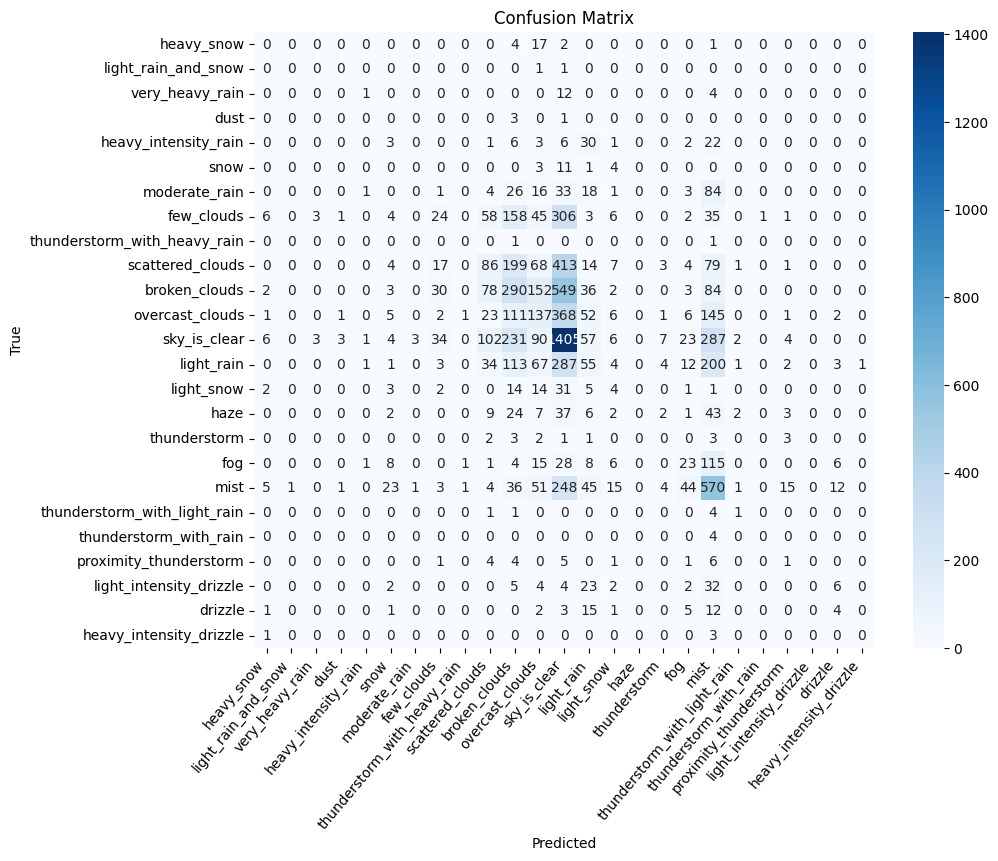

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pd.unique(dataset_test['weather']), yticklabels=pd.unique(dataset_test['weather']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=50, ha = 'right')
plt.title('Confusion Matrix')

In [45]:
# report = classification_report(y_true, y_predicted, labels = pd.unique(dataset_test['weather']))
# print(report)
# with open('metrics_fold0.csv', 'w') as metrics:
#     metrics.write(report)

In [46]:
report_dict = classification_report(y_true, y_predicted, labels = pd.unique(dataset_test['weather']), output_dict= True)
print(report_dict)

# Saval os arquivos
csv_filename = f'metrics_{fold}.csv'

with open(csv_filename, 'w', newline='') as metrics_file:
    metrics_writer = csv.writer(metrics_file)
    
    metrics_writer.writerow(['class', 'precision', 'recall', 'f1-score', 'support'])

    for class_label, metrics in report_dict.items():
        metrics_writer.writerow([class_label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])

{'heavy_snow': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24.0}, 'light_rain_and_snow': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, 'very_heavy_rain': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17.0}, 'dust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'heavy_intensity_rain': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 74.0}, 'snow': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 19.0}, 'moderate_rain': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 187.0}, 'few_clouds': {'precision': 0.20512820512820512, 'recall': 0.036753445635528334, 'f1-score': 0.06233766233766234, 'support': 653.0}, 'thunderstorm_with_heavy_rain': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, 'scattered_clouds': {'precision': 0.2113022113022113, 'recall': 0.09587513935340022, 'f1-score': 0.13190184049079753, 'support': 897.0}, 'broken_clouds': {'precision': 0.2

c:\Users\leand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leand\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [47]:
pd.read_csv(f'metrics_{fold}.csv')

,class,precision,recall,f1-score,support
0,heavy_snow,0.000000,0.000000,0.000000,24.0
1,light_rain_and_snow,0.000000,0.000000,0.000000,2.0
2,very_heavy_rain,0.000000,0.000000,0.000000,17.0
3,dust,0.000000,0.000000,0.000000,4.0
4,heavy_intensity_rain,0.000000,0.000000,0.000000,74.0
5,snow,0.000000,0.000000,0.000000,19.0
6,moderate_rain,0.000000,0.000000,0.000000,187.0
7,few_clouds,0.205128,0.036753,0.062338,653.0
8,thunderstorm_with_heavy_rain,0.000000,0.000000,0.000000,2.0
9,scattered_clouds,0.211302,0.095875,0.131902,897.0


In [48]:
'''dada a complexidade do dataset, e também pela redundancia nas classes, seja pela:

     i. repetição na ocorrencia dos nomes (proximity_thunderstorm, thunderstorm, thunderstorm_with_light_rain )  
    ii. eventos similares, que necessitam de um especialista para diferenciar-los (fog, haze, mist)
   iii. ambos (scattered clouds e broken clouds; few clouds e sky is clear) 

    considera-se um acerto caso o ground truth esteja entre as 4 maiores probabilidades'''

count = 0

for index in dataset_test.index: #testa cada amostra contida no dataset de teste
    current_prediction = {}
    for weather in pd.unique(dataset_test['weather']):
        current_prediction[weather] =  round(
                                            NaiveBayes(
                                                        weather = weather,  
                                                        season_value = dataset_test.loc[index, 'season'], 
                                                        humidity_value = dataset_test.loc[index, 'humidity'], 
                                                        pressure_value = dataset_test.loc[index, 'pressure'], 
                                                        temperature_value =  dataset_test.loc[index, 'temperature'], 
                                                        wind_value = dataset_test.loc[index, 'wind']
                                                        ),
                                            10)
                             

    #verifica a maior probabilidade calculada pelo modelo e a sua classe
    NB_choice = [0,0,0,0,]
    classe1 = 0
    classe2 = 0
    classe3 = 0
    classe4 = 0

    #contagem de acertos do modelo 
    values_mapping = {probability : weather for weather, probability in current_prediction.items()} # salva os valores a predicao atual (para que as probabilidades sejam organizadas em ordem crescente para a comparação)

    for probability in sorted(current_prediction.values()):
        if probability > NB_choice[0]:
            classe1, classe2, classe3, classe4 = values_mapping.get(probability), classe1, classe2, classe3
            NB_choice[0], NB_choice[1], NB_choice[2], NB_choice[3] = probability, NB_choice[0], NB_choice[1],  NB_choice[2]
    
    

    if classe1 == dataset_test.loc[index, 'weather'] or classe2 == dataset_test.loc[index, 'weather'] or classe3 == dataset_test.loc[index, 'weather'] or classe4 == dataset_test.loc[index, 'weather']:
        count+=1
        #print(count,index)

accuracy = count/index
print(f'Considerando as 4 classes como um acerto, a Acurácia é {round(accuracy, 2)}%\n Acertos: {count}\n Total: {index}')

Considerando as 4 classes como um acerto, a Acurácia é 0.71%
 Acertos: 6151
 Total: 8715
